In [1]:
# this needs to be run for each new runtime
# because colab has scikit-learn 1.0.2 pre-installed
# and we need newer version (1.2.0 and higher)
# to use .set_output() method
!pip install scikit-learn --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 19.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


## 1. Data Reading

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Step 1: Extract Sheet ID and Sheet name from the link
link = "https://docs.google.com/spreadsheets/d/110H4-s-g-7sP-cR_hc6DGRX5GcDiazx7HqeW0YCWHS8/edit#gid=936108375"

sheet_id = link.split("/")[5]
sheet_name = link.split("gid=")[1]

# Step 2: Construct the URL
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={sheet_name}"

# Step 3: Read the URL as a pandas DataFrame
tags_df = pd.read_csv(url)

# Print the DataFrame
tags_df

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


In [4]:
# Step 1: Extract Sheet ID and Sheet name from the link
link = "https://docs.google.com/spreadsheets/d/1jMIXfQsJaa7N-n4YvzMaYZiKsVwDvbXc4JN7q5RYtHI/edit#gid=107817544"

sheet_id = link.split("/")[5]
sheet_name = link.split("gid=")[1]

# Step 2: Construct the URL
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={sheet_name}"

# Step 3: Read the URL as a pandas DataFrame
ratings_df = pd.read_csv(url)

# Print the DataFrame
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [5]:
# Step 1: Extract Sheet ID and Sheet name from the link
link = "https://docs.google.com/spreadsheets/d/18jHxe67qCE4R585MPqKhJhKzEFTE1PdcHE6d2n4PT1g/edit#gid=931024804"

sheet_id = link.split("/")[5]
sheet_name = link.split("gid=")[1]

# Step 2: Construct the URL
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={sheet_name}"

# Step 3: Read the URL as a pandas DataFrame
movies_df = pd.read_csv(url)

# Print the DataFrame
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [6]:
# Step 1: Extract Sheet ID and Sheet name from the link
link = "https://docs.google.com/spreadsheets/d/1yKKo_U0txh3wAGJF5f-Mgvf6eHMxdyCHvadtEiEKZ6Q/edit#gid=397468111"

sheet_id = link.split("/")[5]
sheet_name = link.split("gid=")[1]

# Step 2: Construct the URL
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={sheet_name}"

# Step 3: Read the URL as a pandas DataFrame
links_df = pd.read_csv(url)

# Print the DataFrame
links_df

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


## 2. Movie recommendations (Popularity rankings)

#### 2.1 Function creation

In [7]:
def recommend_movies(n, alpha, beta):
    # Calculate the average rating and rating count for each movie
    movie_ratings = ratings_df.groupby('movieId').agg({'rating': ['mean', 'count']}).reset_index()
    movie_ratings.columns = ['movieId', 'avg_rating', 'rating_count']

    # Merge with movies_df to get movie titles and genres
    movie_data = pd.merge(movie_ratings, movies_df, on='movieId')

    # Calculate the weighted average rating
    movie_data['weighted_rating'] = (alpha * movie_data['rating_count'] + beta * movie_data['avg_rating']) / (alpha + beta)

    # Sort the movies by weighted average rating
    sorted_movies = movie_data.sort_values('weighted_rating', ascending=False)

    # Return the top n movies
    top_movies = sorted_movies.head(n)

    return top_movies[['movieId', 'title', 'genres', 'avg_rating', 'rating_count', 'weighted_rating']]




#### 2.1 Function test

In [8]:
n = 10  # Number of movies to recommend
alpha = 0.8  # Weight for rating count
beta = 0.2  # Weight for average rating

recommend_movies(n, alpha, beta)

,movieId,title,genres,avg_rating,rating_count,weighted_rating
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.164134,329,264.032827
277,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.429022,317,254.485804
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.197068,307,246.439414
510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.161290,279,224.032258
1938,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.192446,278,223.238489
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.231076,251,201.646215
418,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,3.750000,238,191.150000
97,110,Braveheart (1995),Action|Drama|War,4.031646,237,190.406329
507,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,3.970982,224,179.994196
461,527,Schindler's List (1993),Drama|War,4.225000,220,176.845000


In [9]:
recommended_movies = recommend_movies(20, alpha=0.3, beta=0.7)
recommended_movies

,movieId,title,genres,avg_rating,rating_count,weighted_rating
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.164134,329,101.614894
277,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.429022,317,98.200315
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.197068,307,95.037948
510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.161290,279,86.612903
1938,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.192446,278,86.334712
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.231076,251,78.261753
418,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,3.750000,238,74.025000
97,110,Braveheart (1995),Action|Drama|War,4.031646,237,73.922152
507,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,3.970982,224,69.979687
461,527,Schindler's List (1993),Drama|War,4.225000,220,68.957500


## 3. Movie recommendations (Item-based collaborative filtering)

In [10]:
import pandas as pd
from scipy.spatial.distance import correlation

# Pivot ratings dataframe to create user-item matrix
user_item_matrix = ratings_df.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Replace NaN values with 0
user_item_matrix = user_item_matrix.fillna(0)
user_item_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
def item_based_solutions(movie_id, n):
    # Calculate the correlation between the selected movie and all other movies
    movie_correlations = user_item_matrix.corrwith(user_item_matrix[movie_id])

    # Create a dataframe with movie correlations and remove NaN values
    movie_correlations_df = pd.DataFrame(movie_correlations, columns=['correlation']).dropna()

    # Merge movie correlations with movie information
    similar_movies = movie_correlations_df.merge(movies_df, left_index=True, right_on='movieId')

    # Sort the movies by correlation in descending order
    similar_movies = similar_movies.sort_values(by='correlation', ascending=False)

    # Select the top N most similar movies (excluding the input movie itself)
    similar_movies = similar_movies.head(n)

    # Return the top N similar movies as a Pandas DataFrame
    return similar_movies[['movieId', 'title', 'genres']]

In [12]:
# Test

# Get the top 5 similar movies to movie with ID 123
similar_movies = item_based_solutions(movie_id=100, n=5)
similar_movies

,movieId,title,genres
88,100,City Hall (1996),Drama|Thriller
25,26,Othello (1995),Drama
312,354,Cobb (1994),Drama
764,1006,"Chamber, The (1996)",Drama
54,61,Eye for an Eye (1996),Drama|Thriller


## 4. Movie recommendations (User-based collaborative filtering)


*   Calculate the cosine similarity between users based on their ratings.
*   Compute the weights for each user's similarity scores.
*   Compute the predicted ratings for unrated movies using weighted averages.
*   Create a function that recommends the top n movies to an inputted userID based on the predicted ratings.





In [13]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def user_based_recommender(user_id, n):
    # Calculate the cosine similarity between users
    user_similarities = cosine_similarity(user_item_matrix)

    # Compute the weights based on user similarities
    weights = user_similarities[user_id] / sum(user_similarities[user_id])

    # Find unrated movies for the user
    unrated_movies = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] == 0].index

    # Compute predicted ratings for unrated movies
    predicted_ratings = pd.DataFrame(user_item_matrix.loc[:, unrated_movies].T.dot(weights),
                                     columns=['predicted_rating'])

    # Merge predicted ratings with movie information
    recommended_movies = predicted_ratings.merge(movies_df, left_index=True, right_on='movieId')

    # Sort recommendations by predicted rating in descending order
    recommended_movies = recommended_movies.sort_values('predicted_rating', ascending=False)

    # Select the top n recommended movies
    recommended_movies = recommended_movies.head(n)

    # Add a column for predicted ratings
    recommended_movies_with_ratings = recommended_movies[['movieId', 'title', 'genres']].copy()
    recommended_movies_with_ratings['predicted_rating'] = recommended_movies['predicted_rating']

    return recommended_movies_with_ratings



In [14]:
# Example usage
user_id = 111
n = 5

recommended_movies = user_based_recommender(user_id, n)
recommended_movies


,movieId,title,genres,predicted_rating
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,2.541020
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,2.228413
97,110,Braveheart (1995),Action|Drama|War,2.138402
507,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,1.887955
898,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,1.870818


## 5. Evaluating recommender systems (Offline evaluation)

*The code performs the following steps:*


1.   Create a new rating column by combining the previous ratings.
2.   Create a pivot table where each row represents a user and each column represents a movie, with the new rating as the values.

3.   Identify the positions of nonzero ratings in the pivot table.

4.   Split the rating positions into train and test sets.

5.   Create the train ratings table by filling zeros for the test positions.

6.   Create the test ratings table by filling zeros for the train positions.

7.   Extract the true test ratings from the users_items table and add them to the test positions dataframe.
8.   Calculate the similarity matrix using cosine similarity for the train set.

9.   Define the recommender function to predict the rating for a user and movie based on weighted ratings.

10.   Calculate the predicted ratings for the test set using the recommender function.

11.   Assign the predicted ratings to the test positions dataframe.

12.  Display the head of the test positions dataframe.

13. Calculate Average Predicted Ratings

14. Calculate Performance Metrics

15. Error Analysis and Visualization







In [15]:
# Create a new rating, by combining the previous ones
full_rating_df = ratings_df.assign(overall_rating=ratings_df.rating)

# Pivot table Users vs Movies for the new rating
users_items = pd.pivot_table(data=full_rating_df, values='overall_rating', index='userId', columns='movieId')
users_items.fillna(0, inplace=True)

# Location of nonzeroes
ratings_pos = pd.DataFrame(np.nonzero(np.array(users_items))).T

# Splitting the locations into train and test
train_pos, test_pos = train_test_split(ratings_pos, random_state=123, test_size=.1)

# Creating the ratings table with only train values
train = np.zeros(users_items.shape)
for pos in train_pos.values:
    train[pos[0], pos[1]] = users_items.iloc[pos[0], pos[1]]
train = pd.DataFrame(train, columns=users_items.columns, index=users_items.index)

# Creating the ratings table with only test values
test = np.zeros(users_items.shape)
for pos in test_pos.values:
    test[pos[0], pos[1]] = users_items.iloc[pos[0], pos[1]]
test = pd.DataFrame(test, columns=users_items.columns, index=users_items.index)

# Extract test ratings and add them to the test_positions
true_test_ratings = []
for row in test_pos.iterrows():
    true_test_ratings.append(users_items.iloc[int(row[1][0]), int(row[1][1])])
test_pos = test_pos.assign(true_rating=true_test_ratings)

# Calculate the similarity matrix for the train set
train_similarity = pd.DataFrame(cosine_similarity(train), columns=train.index, index=train.index)

# Recommender function to predict rating for a user and movie
def recommender(index_pos, column_pos):
    results = pd.DataFrame({'ratings': train.iloc[:, column_pos], 'similarities': train_similarity.iloc[index_pos, :].tolist()})
    results = results.assign(weights=results.similarities / (sum(results.similarities) - 1))
    results = results.assign(weighted_ratings=results.ratings * results.weights)
    return results.weighted_ratings.sum()

# Calculate predicted ratings for the test set
pred_ratings_test = []
for row in test_pos.iterrows():
    pred_ratings_test.append(recommender(index_pos=int(row[1][0]), column_pos=int(row[1][1])))
test_pos = test_pos.assign(pred_rating=pred_ratings_test)

test_pos.head()


,0,1,true_rating,pred_rating
16705,104,7306,5.0,0.137385
3692,21,3012,4.5,0.672706
74367,473,3578,3.0,0.038431
49894,318,8945,4.5,0.064935
84800,549,8532,4.5,0.351212


In [16]:
#Calculate Average Predicted Ratings

# Initialize an empty list to store the average predicted ratings
ratings_list = []

# Iterate over the range of possible real values (1 to 5)
for i in range(1, 6):
    # Filter the test_pos dataframe for rows with true_rating equal to the current real value
    # Calculate the mean of the predicted ratings for those rows
    avg_predicted = test_pos.loc[test_pos.true_rating == i, 'pred_rating'].mean()

    # Append the average predicted rating to the ratings_list
    ratings_list.append(avg_predicted)

# Create a DataFrame to store the real values and corresponding average predicted ratings
avg_ratings_df = pd.DataFrame({'real_value': list(range(1, 6)), 'avg_predicted': ratings_list})

# # Sort the avg_ratings_df DataFrame by the 'avg_predicted' column in ascending order
avg_ratings_df_sorted = avg_ratings_df.sort_values(by='avg_predicted')
avg_ratings_df_sorted


,real_value,avg_predicted
0,1,0.281632
1,2,0.327161
2,3,0.433872
3,4,0.550966
4,5,0.753945


In [17]:
# Performance metrics

mean_absolute_error(test_pos.true_rating, test_pos.pred_rating)

3.00644891379616

In [18]:
# Performance metrics

from sklearn.metrics import r2_score

r2_score_value = r2_score(test_pos['true_rating'], test_pos['pred_rating'])
print("R-squared score:", r2_score_value)


R-squared score: -8.263389365140958


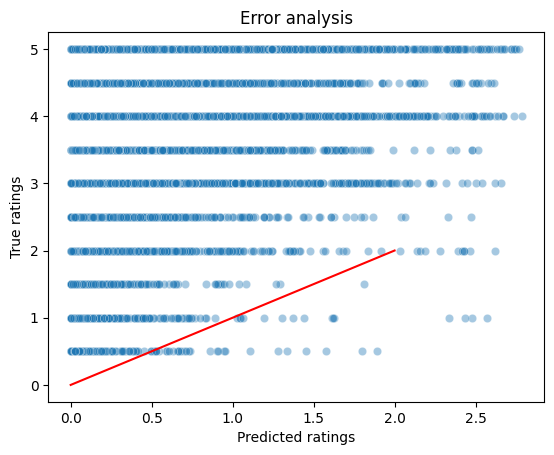

In [19]:
# Plot the error analysis

import matplotlib.pyplot as plt
import seaborn as sns

predictions = test_pos.pred_rating
true_values = test_pos.true_rating

plt.title('Error analysis')
plt.xlabel('Predicted ratings')
plt.ylabel('True ratings')
sns.lineplot(x=[0,2], y=[0,2], color='red')
sns.scatterplot(x=predictions, y=true_values, alpha=0.4)
plt.show()